# Lab 8: Bayes Decision Models Evaluation

In [ ]:
# import
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import sklearn as sk
# note: it is necessarey to install nbimportare before importing it (pip install nbimporter)
import nbimporter 
from lab7_def.lab7.ipynb import calc_logl

ModuleNotFoundError: No module named 'nbimporter'

In [2]:
# Utilities
def labels_to_num(l):
    if l == 'Iris-setosa':
        retval = 0
    elif l == "Iris-versicolor":
        retval = 1
    elif l == "Iris-virginica":
        retval = 2
    return retval

def num_to_labels(l):
    if l == 0:
        retval = "Iris-setosa"
    elif l == 1:
        retval = "Iris-versicolor"
    elif l == 2:
        retval = "Iris-virginica"
    return retval

def vcol(v):
    return np.array(v).reshape(v.size, 1)
def vrow(v):
    return np.array(v).reshape(1, v.size)



In [5]:
# Gaussian classifier (flom lab 6)

# compute the logdensity for a sample x:
def logpdf_GAU_ND(x, mu, C):
    # M = numbers of dimensions
    M = mu.shape[0]
    # N = number of values
    N = x.shape[1]
    C_inv = linalg.inv(C)
    log_N = np.zeros(N)
    _, logdet_C = np.linalg.slogdet(C)
   
    for i in range(N):
        x_i = vcol(x[:, i])
        log_N[i] = (-M/2 * np.log(2 * np.pi) - 0.5 * logdet_C - 0.5 * (x_i - mu).T @ C_inv @ (x_i - mu)).item()
   
    return np.array(log_N)

def loglikelihood(x, mu_ML, C_ML):
    return np.sum(logpdf_GAU_ND(x, mu_ML, C_ML))

# random stuff
def load_iris():
    D,L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L


def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DTE = D[:, idxTest]
    LTR = L[idxTrain]
    LTE = L[idxTest]
    return (DTR, LTR), (DTE, LTE)

# Data
D, L = load_iris()
# DTR and LTR are training data and labels, DTE and LTE are evaluation 
# (or more precisely validation) data and labels
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)
# We use 100 samples for training and 50 samples for evaluation.

# Calculate ML parameters
mu = np.zeros([4, 3])
C = np.zeros([3, 4 , 4])

for l in range(3):
    x_c = DTR[:, LTR == l]
    N_c = x_c.shape[1]
    mu[:, l] = np.mean(x_c, 1)
    delta = x_c - vcol(mu[:, l])
    C[l, :, :] = delta @ delta.T / N_c

# Calculate likelihood 

# S => "scores" matrix
S = np.zeros([3, DTE.shape[1]])

for i in range(3):
    for j in range(S.shape[1]):
        S[i, j] = np.exp(loglikelihood(vcol(DTE[:, j]), vcol(mu[:, i]), C[i, :, :]))

# calculate S_joint and posterior probability
S_joint = S/3
S_marginal = vrow(S_joint.sum(0))

S_post = S_joint / S_marginal
L_pred = S_post.argmax(0)

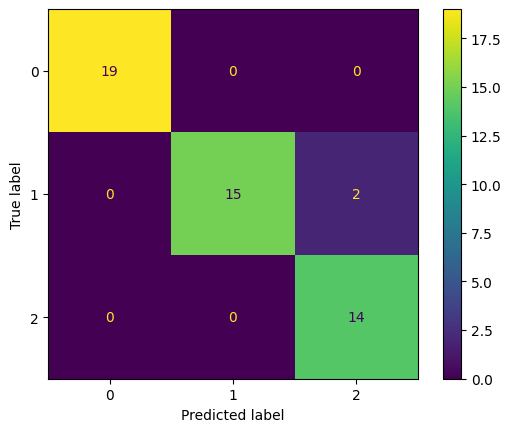

In [7]:
# Computing confusion matrix: (missclassification cost always == 1)
confusion_matrix = sklearn.metrics.confusion_matrix(LTE, L_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2])
cm_display.plot()
plt.show()


Given the limited number of errors, a detailed analysis of the IRIS dataset is not particularly insightful. We therefore shift our focus to a larger evaluation dataset.

In the following, we will use the outputs of the classifier developed in Laboratory 7. This classifier provides class-conditional log-likelihoods. You can load the log-likelihood matrix and the corresponding tercet labels from Data/commedia_ll.npy and Data/commedia_labels.npy.

In [ ]:
# confusion matrix based on lab7
ll = np.load("./Data/commedia_ll.npy")# log likelyhood
actual_labels = np.load("./Data/commedia_labels.npy")

S = np.zeros([3, len(ITE)])
for i in range(len(ITE)):
    tercet = ITE[i]
    S[0, i], S[1, i], S[2, i] = calc_logl(tercet)

S_joint = np.exp(S) * 1/3
S_marginal = vrow(S_joint.sum(0))

S_post = S_joint/S_marginal
L_pred = S_post.argmax(0)